In [1]:
import torch
from statsmodels.stats.proportion import test_proportions_2indep
from src.utils.simulator import ProportionTrafficGenerator
from src.inference.bayesian import BayesianBinaryTester

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 8)

Setting parameters for generating traffic. The traffic is collected every 30 minutes, over a period of 2 weeks. For the small sample, there are 100 visitors every interval, while the larger sample has 1000 visitors. We only direct 10% of the traffic to the variant.

In [2]:
SAMPLING_INTERVAL = torch.tensor(24 * 2) # every half an hour
TEST_DURATION = torch.tensor(14)
TRUE_PROP = torch.tensor([0.1, 0.105])
TRAFFIC_SIZE = torch.tensor(100)
TRAFFIC_SIZE_LARGE = torch.tensor(1000)
TREATMENT_PROPORTION = torch.tensor(0.1)

# Small Sample (N=100 per 30 minute)

In [3]:
traffic_generator = ProportionTrafficGenerator(
    N=SAMPLING_INTERVAL * TEST_DURATION,
    p=TRUE_PROP,
    traffic_size=TRAFFIC_SIZE,
    treatment_proportion=TREATMENT_PROPORTION
)
traffic_generator.generate_traffic()
traffic_generator.sample

tensor([[ 4.,  0.],
        [ 9.,  0.],
        [10.,  0.],
        ...,
        [ 9.,  1.],
        [ 7.,  1.],
        [ 6.,  0.]])

Here is a snippet of the sample traffic. on the left is the number of clicks of the control variant while the right represent the treatment traffic.

## Frequentist

In [4]:
test_proportions_2indep(nobs1=traffic_generator.n0,
                        count1=traffic_generator.x0,
                        nobs2=traffic_generator.n1,
                        count2=traffic_generator.x1,
                        compare='diff',
                        alternative='smaller')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = tensor(-0.9054)
pvalue = 0.18261890393280555
compare = diff
method = agresti-caffo
diff = tensor(-0.0034)
ratio = tensor(0.9666)
odds_ratio = tensor(0.9629)
variance = tensor(1.5179e-05)
alternative = smaller
value = 0
tuple = (tensor(-0.9054), 0.18261890393280555)

The frequentist method does not reject the Null hypothesis at 5%, thus, we will not launch the change even though there is a difference.

## Bayesian 

In [6]:
binary_test = BayesianBinaryTester(traffic_size=torch.tensor([traffic_generator.n0, traffic_generator.n1]), 
                                   outcome=torch.tensor([traffic_generator.x0, traffic_generator.x1]))
binary_test.run()

Sample: 100%|██████████| 1100/1100 [00:09, 115.01it/s, step size=8.59e-01, acc. prob=0.920]


In [7]:
binary_test.summary()

Potential cost of not switching: 0.40%
Cost of wrong switch: 0.03%
Probability of Treatment is better: 83.00%


The test shows that the probability of the treatment being better is 83% thus, as long as we are willing to accept a potential loss of 0.03%, we have a high probability of gaining 0.4% traffic. This illustrates the advantage of the Bayesian test that we weight between the gain and loss.

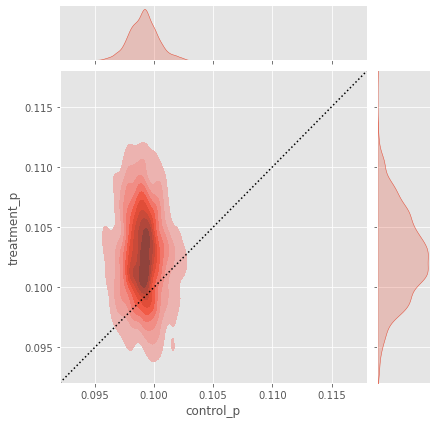

In [8]:
binary_test.plot_joint_posterior()

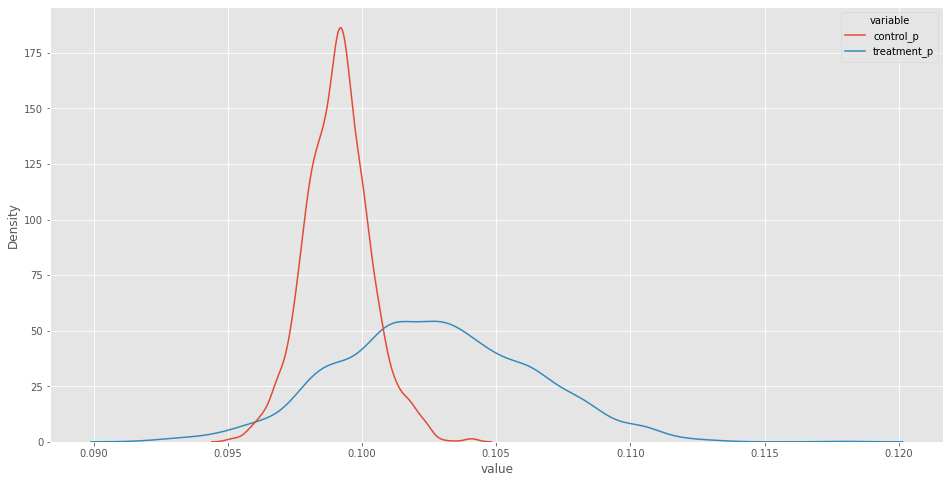

In [9]:
binary_test.plot_posterior()

# Small Sample (N=1000 per 30 minute)

In [10]:
traffic_generator_large = ProportionTrafficGenerator(
    N=SAMPLING_INTERVAL * TEST_DURATION,
    p=TRUE_PROP,
    traffic_size=TRAFFIC_SIZE_LARGE,
    treatment_proportion=TREATMENT_PROPORTION
)
traffic_generator_large.generate_traffic()
traffic_generator_large.sample

tensor([[103.,   9.],
        [ 95.,   9.],
        [114.,  12.],
        ...,
        [ 91.,  11.],
        [ 88.,   9.],
        [ 84.,  11.]])

We now have a larger sample size, but the parameters are all the same.

## Frequentist

In [11]:
test_proportions_2indep(nobs1=traffic_generator_large.n0,
                        count1=traffic_generator_large.x0,
                        nobs2=traffic_generator_large.n1,
                        count2=traffic_generator_large.x1,
                        compare='diff',
                        alternative='smaller')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = tensor(-4.1557)
pvalue = 1.621278125849819e-05
compare = diff
method = agresti-caffo
diff = tensor(-0.0052)
ratio = tensor(0.9508)
odds_ratio = tensor(0.9454)
variance = tensor(1.5432e-06)
alternative = smaller
value = 0
tuple = (tensor(-4.1557), 1.621278125849819e-05)

The null hypothesis is rejected as expected given the large sample size.

In [14]:
binary_test_large_sample = BayesianBinaryTester(traffic_size=torch.tensor([traffic_generator_large.n0, traffic_generator_large.n1]), 
                                                outcome=torch.tensor([traffic_generator_large.x0, traffic_generator_large.x1]))
binary_test_large_sample.run()

Sample: 100%|██████████| 1100/1100 [00:10, 101.13it/s, step size=3.55e-01, acc. prob=0.942]


In [15]:
binary_test_large_sample.summary()

Potential cost of not switching: 0.52%
Cost of wrong switch: 0.00%
Probability of Treatment is better: 100.00%


Although the result is the same that we will also launch the treatment, but we have more confidence in this case knowing that the expected loss is almost 0.

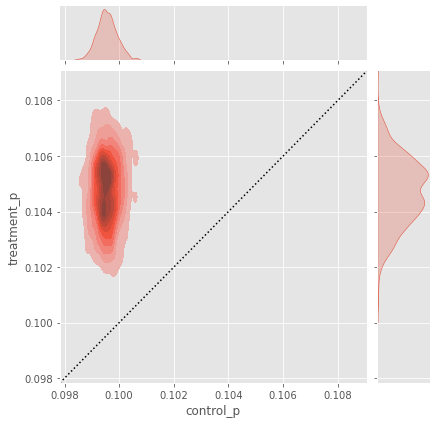

In [16]:
binary_test_large_sample.plot_joint_posterior()

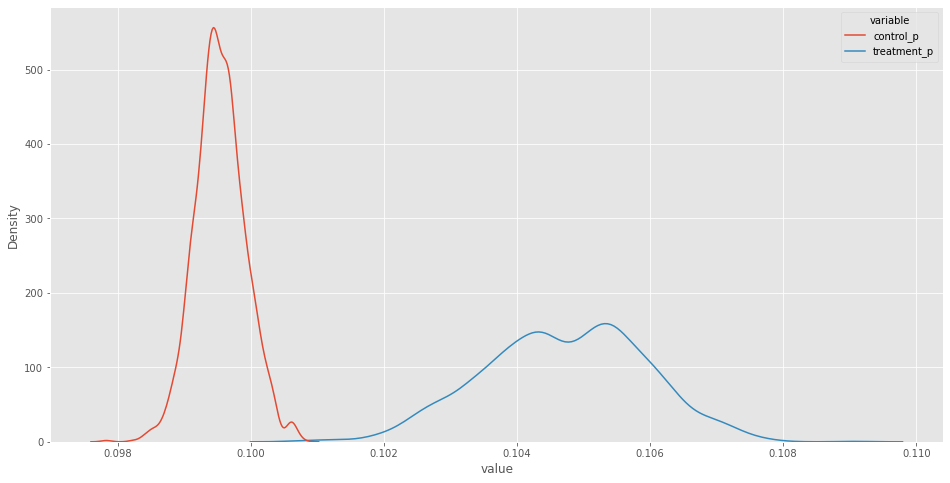

In [17]:
binary_test_large_sample.plot_posterior()